In [1]:
from typing import List, Tuple, Dict
from nptyping import NDArray, Object, Int32


In [2]:
text = "You say goodbye and I say hello."
# 全ての文字を小文字に変換
text = text.lower()
# 文末のピリオドにスペースを加える。分割しやすいように。
text = text.replace(".", " .")
print(text)


you say goodbye and i say hello .


In [3]:
# 文章をスペース単位で区切って単語の集合にする
words = text.split(" ")
print(words)


['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']


In [4]:
# 単語にIDを振って扱いやすい形にする
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word


In [5]:
print(word_to_id)
print(id_to_word)


{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [6]:
import sys

sys.path.append("..")
import numpy as np
from common.util import preprocess

text = "You say goodbye and I say hello."
cropus, world_to_id, id_to_word = preprocess(text)
print(cropus)
print(id_to_word)


[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [7]:
C = np.array(
    [
        [0, 1, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 1, 0],
        [0, 1, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0],
        [0, 1, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0],
    ],
    dtype=np.int32,
)


In [8]:
def create_co_matrix(corpus: List, vocab_size: int, window_size: int = 1) -> NDArray:
    """共起行列の作成

    Args:
        corpus (List): 単語IDのリスト
        vocab_size (int): 語彙数
        window_size (int, optional): ウィンドウサイズ. Defaults to 1.

    Returns:
        NDArray: 共起行列
    """
    corpus_size: int = len(corpus)
    co_matrix: NDArray = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            # 注目単語の左隣
            left_idx: int = idx - i
            # 注目単語の右隣り
            right_idx: int = idx + i

            # コーパスの左端をはみ出していないか
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
            # コーパスの右端をはみ出していないか
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix


In [9]:
def cos_similarity(x: NDArray, y: NDArray, eps: float = 1e-8) -> float:
    """コサイン類似度

    Args:
        x (NDArray): ベクトルx
        y (NDArray): ベクトルy
        eps (float, optional): ゼロ除算を防止する定数. Defaults to 1e-8.

    Returns:
        float: コサイン類似度
    """
    nx = x / (np.sqrt(np.sum(x**2)) + eps)  # xの正規化
    ny = y / (np.sqrt(np.sum(y**2)) + eps)  # yの正規化
    return np.dot(nx, ny)


In [10]:
from common.util import preprocess, create_co_matrix, cos_similarity

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id["you"]]
c1 = C[word_to_id["i"]]
print(cos_similarity(c0, c1))


0.7071067691154799


上記の結果から、youとiのコサイン類似度は0.7という結果になった。比較的類似性が高い。

In [11]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    """類似単語のランキングを表示

    Args:
        query (_type_): クエリ(単語)
        word_to_id (_type_): _description_
        id_to_word (_type_): _description_
        word_matrix (_type_): 単語ベクトルをまとめた行列
        top (int, optional): 上位何位まで表示するか. Defaults to 5.
    """
    # クエリを取り出す
    if query not in word_to_id:
        print("%s is not found" % query)
        return
    print("\n[query] " + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # コサイン類似度
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    # コサイン類似度の結果から、その値を高い順に出力
    count = 0
    for i in (-1 * similarity).argsort():
        # argsort()はNumpy配列の要素を小さい順に返す。ただし、インデックスで返す。
        # ここでは大きい順にしたいので、-1をかける。
        if id_to_word[i] == query:
            continue
        print("%s: %s" % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return


In [12]:
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar("you", word_to_id, id_to_word, C, top=5)



[query] you
goodbye: 0.7071067691154799
i: 0.7071067691154799
hello: 0.7071067691154799
say: 0.0
and: 0.0


In [13]:
def ppmi(C, verbose=False, eps=1e-8):
    """相互情報量(Pointwise Mutual Information)を算出する

    Args:
        C (_type_): 共起行列
        verbose (bool, optional): _description_. Defaults to False.
        eps (_type_, optional): _description_. Defaults to 1e-8.

    Returns:
        _type_: _description_
    """
    M = np.zeros_like(C, dtype=np.float32)
    # 共起行列の1の総和を計算
    N = np.sum(C)
    # axis=0とすることで、各列の総和を1行にまとめる。
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):  # 行
        for j in range(C.shape[1]):  # 列
            # 相互情報量
            pmi = np.log2(C[i, j] * N / (S[j] * S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total // 100 + 1) == 0:
                    print("%.1f%% done" % (100 * cnt / total))
    return M


In [14]:
text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)
np.set_printoptions(precision=3)
print("convariance matrix")
print(C)
print("-" * 50)
print("PPMI")
print(W)


convariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


In [15]:
S = np.sum(C, axis=0)
print(S)
print(np.sum(C))


[1 4 2 2 2 2 1]
14


In [16]:
W = ppmi(C)
U, S, V = np.linalg.svd(W)
print(C[0])
print(W[0])
print(U[0])


[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 3.409e-01 -1.110e-16 -1.205e-01 -4.163e-16 -9.323e-01 -1.110e-16
 -2.426e-17]


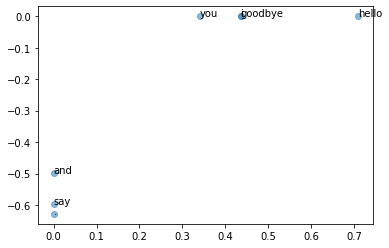

In [17]:
from matplotlib import pyplot as plt

for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:, 0], U[:, 1], alpha=0.5)
plt.show()


In [18]:
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data("train")
print("corpus size:", len(corpus))
print("corpus[:30]:", corpus[:30])
print()
print("id_to_word[0]:", id_to_word[0])
print("id_to_word[1]:", id_to_word[1])
print("id_to_word[2]:", id_to_word[2])
print()
print("word_to_id['car']", word_to_id["car"])
print("word_to_id['happy']", word_to_id["happy"])
print("wor_to_id['lexus']", word_to_id["lexus"])


corpus size: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car'] 3856
word_to_id['happy'] 4428
wor_to_id['lexus'] 7426


In [19]:
# ハイパーパラメータの設定
window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data("train")
vocab_size = len(word_to_id)
print("counting co-occurrence ...")
C = create_co_matrix(corpus, vocab_size, window_size)
print("calculating PPMI ...")
W = ppmi(C, verbose=False)

print("calculating SVD ...")
try:
    from sklearn.utils.extmath import randomized_svd
    # n_components:抽出する特異値とベクトルの数
    U, S, V = randomized_svd(W, n_components=wordvec_size,n_iter=5, random_state=None)
except ImportError:
    U, S, V = np.linalg.svd(W)

# 密なベクトルをwordvec_sizeに次元削減する
word_vecs = U[:, :wordvec_size]
querys = ["you", "year", "car", "toyota"]
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


counting co-occurrence ...
calculating PPMI ...
calculating SVD ...

[query] you
we: 0.6496771574020386
i: 0.6095696091651917
anybody: 0.5571151375770569
do: 0.5344875454902649
somebody: 0.5246504545211792

[query] year
month: 0.7059341073036194
quarter: 0.6444454193115234
last: 0.6080682873725891
earlier: 0.5977609157562256
next: 0.5866934657096863

[query] car
auto: 0.7008335590362549
luxury: 0.6989321708679199
truck: 0.5502275824546814
corsica: 0.5256978273391724
cars: 0.5106109380722046

[query] toyota
motor: 0.7233158349990845
honda: 0.647767186164856
nissan: 0.6344736218452454
lexus: 0.6017746329307556
motors: 0.5931701064109802
